# LSTM Overview
This notebook follows data normalization, a univaraite LSTM model, a single step model, and a multistep predictive model. Given the nature of the model the single step and multistep both only look a single step (day) in the future, but the multistep model was necessary to test some further windows of prediction.

In [1]:
import tensorflow as tf
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

%matplotlib inline

In [2]:
#train_test = pd.read_csv("./keras_training_testing.csv")
#train_test = pd.read_csv("/Users/mw2931/Desktop/Thesis/LSTM/keras_nolag_completes.csv")
train_test = pd.read_csv("/Users/mw2931/Desktop/Thesis/LSTM/keras_nolag_completes_interday.csv")



In [3]:
train_test.head()

,index,value,VIX_Close,Monday,Tuesday,Wednesday,Thursday,Friday,tax_dummy,week_1,...,Queens Ozone Data,CO_Daily_8hr_Average_PPM,Queens CO Data,mean_hr_dewpoint_tempF,mean_hr_tempF,mean_hr_pressure_psi,mean_hr_windspeed_knots,mean_hr_precip_in,mean_hr_clouds_percent,pm2.5_Daily_Lag1
0,2006-12-27,0.701527,10.64,0,0,1,0,0,0,0,...,1,2.533333,1,30.15625,44.81250,29.705938,17.56250,0.0,0.890625,268.0
1,2006-12-28,-0.147878,10.99,0,0,0,1,0,0,0,...,1,3.533333,1,23.84375,42.25000,30.268750,11.40625,0.0,0.690476,246.1
2,2006-12-29,-0.451309,11.56,0,0,0,0,1,0,0,...,1,4.170833,1,31.09375,46.87500,30.525938,7.81250,0.0,0.796875,393.5
3,2007-01-03,-0.119867,12.04,0,0,1,0,0,1,1,...,1,5.487500,1,24.56250,45.28125,30.337812,9.06250,0.0,0.507812,429.0
4,2007-01-04,0.122829,11.51,0,0,0,1,0,1,1,...,1,5.229167,1,33.75000,49.12500,30.185000,10.68750,0.0,0.687500,370.9


## Univariate Data

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [5]:
TRAIN_SPLIT = 2335

In [6]:
tf.random.set_seed(13)

In [7]:
uni_data = train_test['value']
uni_data.index = train_test['index']
uni_data.head()

index
2006-12-27    0.701527
2006-12-28   -0.147878
2006-12-29   -0.451309
2007-01-03   -0.119867
2007-01-04    0.122829
Name: value, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1058a4cf8>],
      dtype=object)

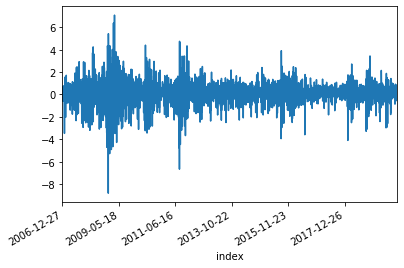

In [8]:
uni_data.plot(subplots=True)

In [9]:
uni_data = uni_data.values

In [10]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

z score transformation

In [11]:
uni_data = (uni_data-uni_train_mean)/uni_train_std


In [12]:
univariate_past_history = 38
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [13]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])


Single window of past history
[[ 0.58172771]
 [-0.16219163]
 [-0.42793958]
 [-0.13765901]
 [ 0.07489658]
 [-0.56557285]
 [ 0.16177992]
 [-0.07792926]
 [-0.31831382]
 [ 0.6327189 ]
 [ 0.63679926]
 [ 0.05819551]
 [-0.10902978]
 [ 0.21643031]
 [-0.15568159]
 [-0.10778393]
 [-0.34478888]
 [-0.1425142 ]
 [-3.0739692 ]
 [ 0.45435101]
 [-0.25990172]
 [-1.0313444 ]
 [-0.8566135 ]
 [ 1.32426765]
 [-0.24858938]
 [ 0.5914797 ]
 [ 0.02666875]
 [ 0.20206427]
 [-1.81655594]
 [ 0.55334202]
 [ 0.28994879]
 [-0.36796588]
 [ 0.92147367]
 [ 0.52201306]
 [ 1.4632853 ]
 [-0.06319338]
 [ 0.06316979]
 [ 0.05209192]]

 Target temperature to predict
-0.5743114216043564


In [14]:
def create_time_steps(length):
  return list(range(-length, 0))

In [15]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/Users/mw2931/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

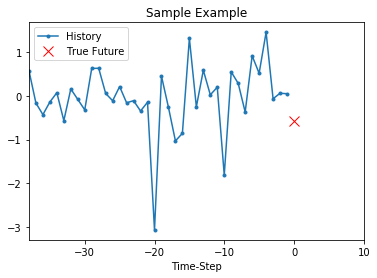

In [16]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


In [17]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/mw2931/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

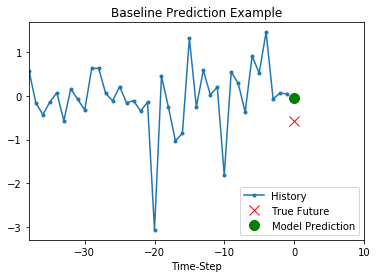

In [18]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [19]:
BATCH_SIZE = 389
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [20]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])


In [21]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(389, 1)


# Epochs and Evaluation Interval set here!

In [22]:
EVALUATION_INTERVAL = len(y_train_uni)
EPOCHS = 1

In [23]:
simple_lstm_history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=1)

2297/2297 [==============================] - 52s 23ms/step - loss: 0.9727 - root_mean_squared_error: 0.9863 - val_loss: 0.5085 - val_root_mean_squared_error: 0.7131


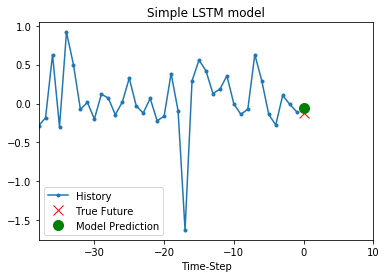

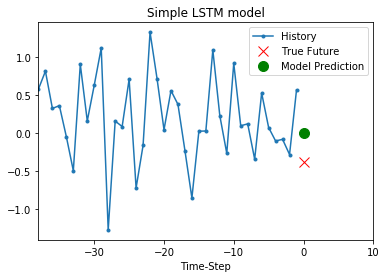

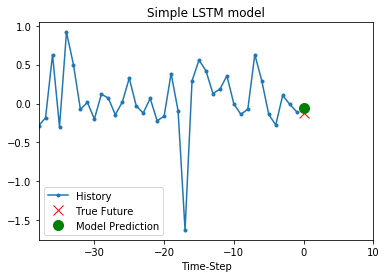

In [24]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

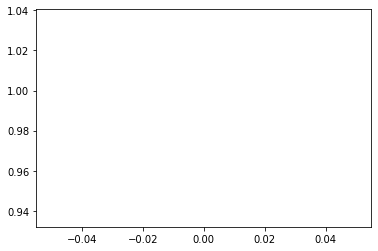

In [25]:
plt.plot(simple_lstm_history.history['root_mean_squared_error'])
plt.show()

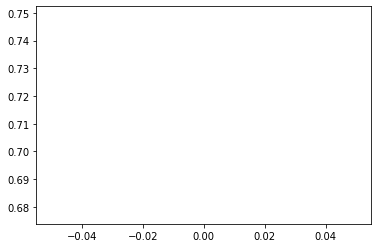

In [26]:
plt.plot(simple_lstm_history.history['val_root_mean_squared_error'])
plt.show()

In [27]:
simple_lstm_history.history['root_mean_squared_error'][EPOCHS-1]

0.9862738847732544

In [28]:
simple_lstm_history.history['val_root_mean_squared_error'][EPOCHS-1]

0.7131067514419556

## Multivariate Model
Below is a test whree the data was split into training and testing to ensure that it was properly divided

In [29]:
#train = train_test['key'] == "Training"
#train = train_test[train]
#train = train.drop(columns=['key'])
#test = train_test['key'] == "Testing"
#test = train_test[test]
#test = test.drop(columns=['key'])

train = train_test.iloc[0:2335,]
test = train_test.iloc[2335:, ]

len(train)
len(test)

630

In [30]:
train.tail()

,index,value,VIX_Close,Monday,Tuesday,Wednesday,Thursday,Friday,tax_dummy,week_1,...,Queens Ozone Data,CO_Daily_8hr_Average_PPM,Queens CO Data,mean_hr_dewpoint_tempF,mean_hr_tempF,mean_hr_pressure_psi,mean_hr_windspeed_knots,mean_hr_precip_in,mean_hr_clouds_percent,pm2.5_Daily_Lag1
2330,2017-04-07,-0.082713,12.87,0,0,0,0,1,0,0,...,0,2.002550,1,38.794872,49.641026,29.311290,12.871795,0.020952,0.745968,50.5
2331,2017-04-11,-0.143388,15.07,0,1,0,0,0,0,0,...,0,2.483085,1,46.437500,67.156250,30.105000,8.937500,0.000000,0.729167,203.5
2332,2017-04-12,-0.375995,15.77,0,0,1,0,0,0,0,...,0,3.311552,1,51.000000,63.656250,30.101250,5.437500,0.001250,0.776042,274.5
2333,2017-04-13,-0.681469,15.96,0,0,0,1,0,0,0,...,0,2.003047,1,37.125000,59.500000,30.270625,11.031250,0.000000,0.531250,415.9
2334,2017-04-17,0.861335,14.66,1,0,0,0,0,0,0,...,0,1.662700,1,49.696970,72.151515,29.876250,13.696970,0.000000,0.750000,133.1


In [31]:
test.head()
#len(test)

,index,value,VIX_Close,Monday,Tuesday,Wednesday,Thursday,Friday,tax_dummy,week_1,...,Queens Ozone Data,CO_Daily_8hr_Average_PPM,Queens CO Data,mean_hr_dewpoint_tempF,mean_hr_tempF,mean_hr_pressure_psi,mean_hr_windspeed_knots,mean_hr_precip_in,mean_hr_clouds_percent,pm2.5_Daily_Lag1
2335,2017-04-18,-0.290338,14.42,0,1,0,0,0,0,0,...,0,1.277231,1,31.000000,60.625000,30.223125,11.750000,0.000000,0.447917,122.5
2336,2017-04-19,-0.171635,14.93,0,0,1,0,0,0,0,...,0,1.087833,1,37.736842,50.605263,30.474375,12.842105,0.000000,0.675000,90.0
2337,2017-04-20,0.755726,14.15,0,0,0,1,0,0,0,...,0,1.732133,1,45.510638,52.319149,30.169375,8.085106,0.017273,0.967949,96.0
2338,2017-04-21,-0.303507,14.63,0,0,0,0,1,0,0,...,0,1.370073,1,47.490196,52.705882,29.985937,12.117647,0.009167,0.997093,173.6
2339,2017-04-24,1.084007,10.84,1,0,0,0,0,0,0,...,0,2.463872,1,42.875000,53.500000,30.129062,7.343750,0.000000,0.911458,96.4


In [32]:
features_considered = list(train.drop(columns=['index']).columns) 
features = train_test[features_considered]
features.index = train_test['index']
features.head()

,value,VIX_Close,Monday,Tuesday,Wednesday,Thursday,Friday,tax_dummy,week_1,week_2,...,Queens Ozone Data,CO_Daily_8hr_Average_PPM,Queens CO Data,mean_hr_dewpoint_tempF,mean_hr_tempF,mean_hr_pressure_psi,mean_hr_windspeed_knots,mean_hr_precip_in,mean_hr_clouds_percent,pm2.5_Daily_Lag1
index,,,,,,,,,,,,,,,,,,,,,
2006-12-27,0.701527,10.64,0,0,1,0,0,0,0,0,...,1,2.533333,1,30.15625,44.81250,29.705938,17.56250,0.0,0.890625,268.0
2006-12-28,-0.147878,10.99,0,0,0,1,0,0,0,0,...,1,3.533333,1,23.84375,42.25000,30.268750,11.40625,0.0,0.690476,246.1
2006-12-29,-0.451309,11.56,0,0,0,0,1,0,0,0,...,1,4.170833,1,31.09375,46.87500,30.525938,7.81250,0.0,0.796875,393.5
2007-01-03,-0.119867,12.04,0,0,1,0,0,1,1,0,...,1,5.487500,1,24.56250,45.28125,30.337812,9.06250,0.0,0.507812,429.0
2007-01-04,0.122829,11.51,0,0,0,1,0,1,1,0,...,1,5.229167,1,33.75000,49.12500,30.185000,10.68750,0.0,0.687500,370.9


array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d2aec88>,
      dtype=object)

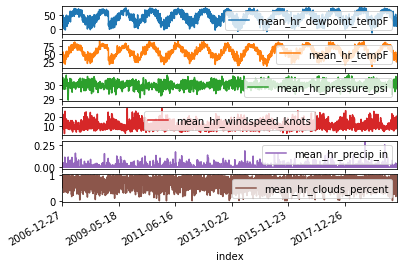

In [33]:
weather = ['mean_hr_dewpoint_tempF', 'mean_hr_tempF', 'mean_hr_pressure_psi', 'mean_hr_windspeed_knots', 'mean_hr_precip_in', 'mean_hr_clouds_percent']
features[weather].plot(subplots = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13dddc390>,
      dtype=object)

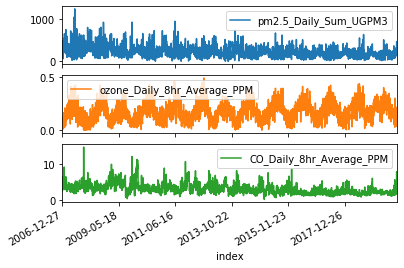

In [34]:
pollution = ['pm2.5_Daily_Sum_UGPM3', 'ozone_Daily_8hr_Average_PPM', 'CO_Daily_8hr_Average_PPM']
features[pollution].plot(subplots = True)

In [35]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [36]:
dataset = (dataset-data_mean)/data_std

In [37]:
from pandas import Series
from sklearn.preprocessing import StandardScaler
from math import sqrt
# define contrived series
# prepare data for normalization
test_dataset = features.values

#print(test_dataset)
# train the normalization
scaler = StandardScaler()
scaler = scaler.fit(test_dataset)
#print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# normalize the dataset and print
standardized = scaler.transform(test_dataset)
print(standardized)
# inverse transform and print
inversed = scaler.inverse_transform(standardized)
#print(inversed)
#print(dataset)

[[ 0.60946152 -1.09176677 -0.47935391 ... -0.38757663  0.78274756
   0.29036904]
 [-0.17995513 -1.04324016 -0.47935391 ... -0.38757663 -0.05412412
   0.12970228]
 [-0.46195594 -0.9642111  -0.47935391 ... -0.38757663  0.39075562
   1.21108497]
 ...
 [-0.03936226 -0.70494033 -0.47935391 ... -0.38757663  1.18199862
   1.38569085]
 [-0.57977611 -0.51222034  2.08614131 ...  0.91324167  1.2400715
  -0.06911367]
 [ 0.23127524 -0.65641371 -0.47935391 ... -0.02332675  1.11259444
  -0.75726628]]


### Single Step Model

In [38]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

We have to determine how far back to look, which is complicated since we don't have 100% of days accounted for and no weekends. We have approximately 19 days per month on average, so maybe we take the last two months.

After some experimentation, 57 days, or about 3 months, seemed to perform better. The sampling is done every one day except weekends, thus, 19 observation represent history of the last average month. For the single step prediction model, the label for a datapoint is the percent return 1 day into the future. In order to create a label for this, the percent return after 1 observations is used. What's complicated is that our data is already lagged so we may have to correct the data.

In [39]:
#EVALUATION_INTERVAL = len(y_train_single)
EPOCHS = 20
past_history = 38 # the last 3 months of data
future_target = 0 # the next value to predict
STEP = 1 # it will take every value rather than skipping any

In [40]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 0], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 0],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [41]:
EVALUATION_INTERVAL = len(y_train_single)

In [42]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (38, 73)


In [43]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

Below in comments we have the basic single step model and then below that is a more advanced single step model.

In [44]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(72,
                                          return_sequences=True,
                                          input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.LSTM(72, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
single_step_model.add(tf.keras.layers.LSTM(72, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
single_step_model.add(tf.keras.layers.LSTM(72, activation='relu', dropout=0.2, recurrent_dropout=0.2))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0, learning_rate=0.001), loss='mse', metrics=['mse','mae', 'accuracy', tf.keras.metrics.RootMeanSquaredError()]) # use MSE because we use RMSE

Sample prediction

In [45]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(389, 1)


In [46]:
tf.random.set_seed(20200714)
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=1)

Epoch 1/20
2297/2297 [==============================] - 1415s 616ms/step - loss: 0.4589 - mse: 0.4589 - mae: 0.4596 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.6774 - val_loss: 0.9974 - val_mse: 0.9974 - val_mae: 0.6845 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.9987
Epoch 2/20
2297/2297 [==============================] - 1177s 512ms/step - loss: 0.0424 - mse: 0.0424 - mae: 0.1526 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.2058 - val_loss: 0.7383 - val_mse: 0.7383 - val_mae: 0.6106 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.8592
Epoch 3/20
2297/2297 [==============================] - 1147s 500ms/step - loss: 0.0190 - mse: 0.0190 - mae: 0.1009 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.1377 - val_loss: 0.7229 - val_mse: 0.7229 - val_mae: 0.6088 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 0.8503
Epoch 4/20
2297/2297 [==============================] - 1173s 511ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0825 - acc

Validation RMSE is 0.7979

In [47]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  #loss = history.history['root_mean_squared_error']
  #val_loss = history.history['val_root_mean_squared_error']
    
  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss (MSE)')
  plt.plot(epochs, val_loss, 'r', label='Validation loss (MSE)')
  plt.title(title)
  plt.legend()

  plt.show()

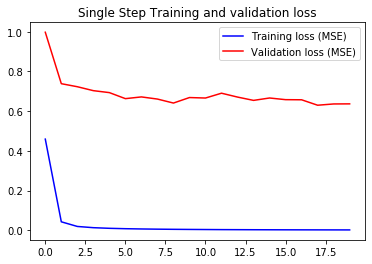

In [48]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [49]:
def plot_train_history_rmse(history, title):
  loss = history.history['root_mean_squared_error']
  val_loss = history.history['val_root_mean_squared_error']
    
  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss (RMSE)')
  plt.plot(epochs, val_loss, 'r', label='Validation loss (RMSE)')
  plt.title(title)
  plt.legend()

  plt.show()

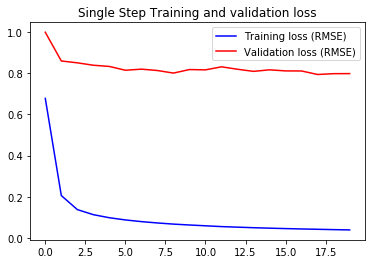

In [50]:
plot_train_history_rmse(single_step_history,
                   'Single Step Training and validation loss')

In [51]:
#for x, y in val_data_single.take(5):
#  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
#                    single_step_model.predict(x)[0]], 0,
#                   'Single Step Prediction')
#  plot.show()

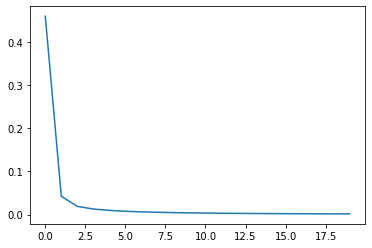

In [52]:
plt.plot(single_step_history.history['mse'])
plt.show()

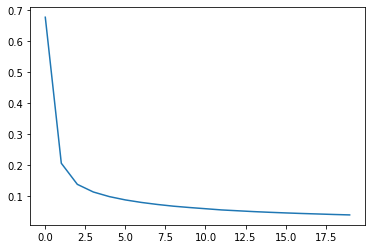

In [53]:
plt.plot(single_step_history.history['root_mean_squared_error'])
plt.show()

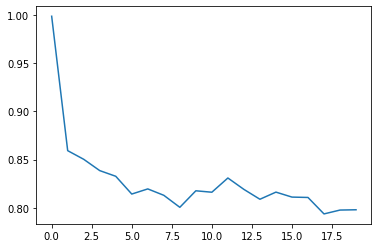

In [54]:
plt.plot(single_step_history.history['val_root_mean_squared_error'])
plt.show()

In [55]:
value = float(single_step_history.history['val_root_mean_squared_error'][EPOCHS-1])
print(value)

0.7978781461715698


So the single step models' RMSE is 0.7844660878181458

In [56]:
single_step_history.history['val_root_mean_squared_error'][EPOCHS-1]

0.7978781461715698

In [57]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [58]:
#for x, y in train_data_single.take(3):
#  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of 4 LSTM layers. Finally, since 1, the dense layer output 1 predictions.

Below we have a basic model followed by a more complicated model used in the final project.

I think we should use MSE vs mae for the loss function since we are concerned with RMSE, correct?

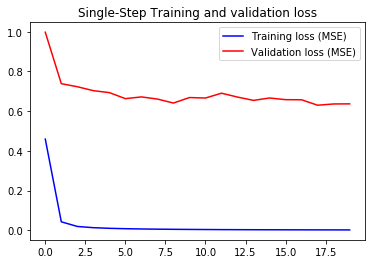

In [59]:
plot_train_history(single_step_history, 'Single-Step Training and validation loss')

In [60]:
#for x, y in val_data_single.take(3):
#  multi_step_plot(x[0], y[0], single_step_model.predict(x)[0])

In [61]:
single_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 38, 72)            42048     
_________________________________________________________________
lstm_2 (LSTM)                (None, 38, 72)            41760     
_________________________________________________________________
lstm_3 (LSTM)                (None, 38, 72)            41760     
_________________________________________________________________
lstm_4 (LSTM)                (None, 72)                41760     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 73        
Total params: 167,401
Trainable params: 167,401
Non-trainable params: 0
_________________________________________________________________


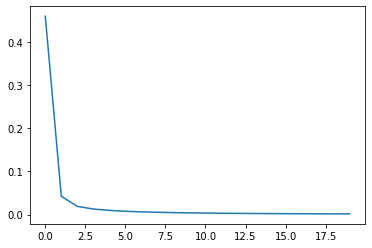

In [62]:
plt.plot(single_step_history.history['mse'])
plt.show()

In [63]:
value = float(single_step_history.history['val_mse'][19])
value

0.6366094946861267

## Getting RMSE

In [64]:
#print(multi_step_history.history['loss'])
#print(multi_step_history.history['accuracy'])
#print(multi_step_history.result().numpy())

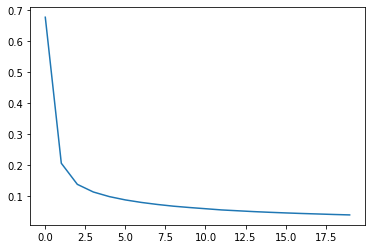

In [65]:
plt.plot(single_step_history.history['root_mean_squared_error'])
plt.show()


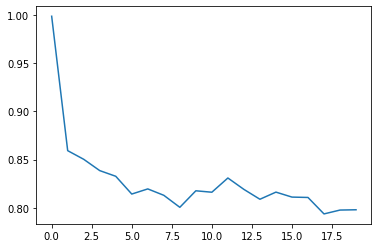

In [66]:
plt.plot(single_step_history.history['val_root_mean_squared_error'])
plt.show()


In [67]:
single_step_history.history['val_root_mean_squared_error'][19]

0.7978781461715698

In [68]:
single_step_history.history['root_mean_squared_error'][19]

0.03898954018950462

# Trying to export an array of predicted values

In [69]:
single_predictions = single_step_model.predict(x_val_single)
#plot = show_plot(y_val_single, single_predictions.numpy(), 'Single Step Prediction')
#plot.show()

In [70]:
len(y_val_single)
#y_val_single

592

In [71]:
len(x_val_single)

592

In [72]:
predictions = single_step_model.predict(x_val_single)
len(predictions)
#predictions

592

In [73]:
predictions.shape

(592, 1)

In [74]:
y_val_single.shape

(592,)

In [75]:
# Reshape to get it in the proper 2D format

y_val_single_norm = np.reshape(y_val_single, (592, 1))

y_val_single_norm.ndim

2

In [76]:
#dataset = (dataset-data_mean)/data_std

#pred_norm = (predictions*test_std)+test_mean
pred_norm = (predictions*data_std)+data_mean
pred_norm.shape

(592, 73)

In [77]:
#y_val_single_norm = (y_val_single_norm*test_std)+test_mean
y_val_single_norm = (y_val_single_norm*data_std)+data_mean
y_val_single_norm.shape

(592, 73)

In [78]:
#pd.DataFrame(y_val_single).to_csv("/Users/mw2931/Desktop/Thesis/LSTM/lstm_true_values.csv")
#pd.DataFrame(predictions).to_csv("/Users/mw2931/Desktop/Thesis/LSTM/lstm_predicted_values.csv")


In [79]:
pd.DataFrame(y_val_single_norm).to_csv("/Users/mw2931/Desktop/Thesis/LSTM/lstm_true_values_normalized_ADJUSTED_lowrmse.csv")
pd.DataFrame(pred_norm).to_csv("/Users/mw2931/Desktop/Thesis/LSTM/lstm_predicted_values_normalized_ADJUSTED_lowrmse.csv")


In [80]:
print("success")

success
